# Наивный байесовский спам-фильтр (Много цифр)

## 1. Описание проекта

Требуется разработать алгоритм фильтрации твитов, в которых обсуждается приложение Mandrill (полезные сообщения, ham), от твитов, содержащих слово Mandrill в иных контекстах (бесполезные сообщения, spam).

Язык реализации алгоритма &mdash; Python. Точность классификации (accuracy) должна превышать 80%.

## 2. Описание данных

Иходные данные представляют собой две размеченные таблицы со спам и не спам сообщениями по 150 сообщений в каждой. 

## 3. Загрузка и предобработка данных

Модули и функции.

In [16]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import re
#import nltk
import spacy
import squarify
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Функция классификации сообщения `classify()` вычисляет ненормированные условные вероятности по формулам:

$P(Spam|w_1,w_2,...,w_n) \propto P(Spam) \prod\limits_{i=1}^n P(w_i|Spam),$

$P(Ham|w_1,w_2,...,w_n) \propto P(Ham) \prod\limits_{i=1}^n P(w_i|Ham).$

In [18]:
spacy.cli.download('en_core_web_sm')
SPACY_NLP = spacy.load('en_core_web_sm')
SPACY_SW = spacy.lang.en.stop_words.STOP_WORDS

def spacy_lemmatize(message):
  '''
  Лемматизация строки
  Args:
    mwssage (str): строка на латинице
  Returns:
    list: список токенов (строк)
  '''

  doc = SPACY_NLP(message)
  return [token.lemma_ for token in doc] # token.text

def remove_stopwords(tokens):
  '''
  Удаление стоп-слов из списка токенов
  Args:
    tokens (list): список токенов (строк)
  Returns:
    list: список токенов
  '''

  cleaned_tokens = []
  for token in tokens:
      if token not in SPACY_SW:
          cleaned_tokens.append(token)
  return cleaned_tokens

def remove_single_characters(tokens):
  '''
  Удаление строк из одного символа из списка токенов
  Args:
    tokens (list): список токенов (строк)
  Returns:
    list: список токенов
  '''

  cleaned_tokens = []
  for token in tokens:
      if len(token) > 1:
          cleaned_tokens.append(token)
  return cleaned_tokens

def preprocess_message(message):
  '''
  Токенизация строки и очистка списка токенов: удаление пунктуации, стоп-слов и
  одиночных символов
  Args:
    mwssage (str): строка на латинице
  Returns:
    list: список токенов
  '''

  message = message.lower()
  message = re.sub(r'[^A-Za-z0-9]+', ' ', message)
  tokens = spacy_lemmatize(message)
  tokens = remove_stopwords(tokens)
  tokens = remove_single_characters(tokens)
  return tokens

def classify(message, p_ham=0.5):
  '''
  Классификация сообщения. Сообщеине токенизируется, удаляется пунктуация, стоп-
  слова и одиночные символы. Классификация осуществляется наивным байесовским
  спам-фильтром из условных вероятностей P(spam|message) и P(ham|message),
  вычисляемых для входного сообщения. Функция возвращаяет имя класса: 'ham',
  'spam', 'unknown'. 'unknown' возвращается, когда условные вероятности равны
  Args:
    mwssage (str): строка на латинице
  Returns:
    str: имя класса
  '''

  tokens = preprocess_message(message)

  p_spam_given_message = (1-p_ham)
  p_ham_given_message = p_ham

  for word in tokens:
    if word in p_word_given_spam:
        p_spam_given_message *= p_word_given_spam[word]
    if word in p_word_given_ham: 
        p_ham_given_message *= p_word_given_ham[word]

  if p_ham_given_message > p_spam_given_message:
    return 'ham'
  elif p_spam_given_message > p_ham_given_message:
    return 'spam'
  else:
    return 'unknown'

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  %cd './drive/MyDrive/Colab Notebooks/Data/Байесовская_фильтрация_спама'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/MyDrive/Colab Notebooks/Data/Байесовская_фильтрация_спама'
/content/drive/MyDrive/Colab Notebooks/Data/Байесовская_фильтрация_спама


Загрузка датасета из книги [Много цифр. Анализ больших данных при помощи Excel.](https://books.google.ru/books/about/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE_%D1%86%D0%B8%D1%84%D1%80_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B1%D0%BE%D0%BB.html?id=gfzkDQAAQBAJ&source=kp_book_description&redir_esc=y).

In [20]:
file_name = './Mandrill.xlsx'
mandrill = pd.pandas.read_excel(file_name, sheet_name='AboutMandrillApp',
    header=0, usecols=['Tweet']
)
other = pd.pandas.read_excel(file_name, sheet_name='AboutOther',
    header=0, usecols=['Tweet']
)
mandrill = mandrill.rename(columns={'Tweet': 'Text'})
other = other.rename(columns={'Tweet': 'Text'})
mandrill['Label'] = 'ham'
other['Label'] = 'spam'
msg = pd.concat([mandrill, other], axis=0)
msg = msg.reset_index(drop=True)
msg.head(10)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Text,Label
0,[blog] Using Nullmailer and Mandrill for your ...,ham
1,[blog] Using Postfix and free Mandrill email s...,ham
2,@aalbertson There are several reasons emails g...,ham
3,@adrienneleigh I just switched it over to Mand...,ham
4,@ankeshk +1 to @mailchimp We use MailChimp for...,ham
5,@biggoldring That error may occur if unsupport...,ham
6,@BlueHayes mind sending us some details about ...,ham
7,"@cemsisman It can vary, but if sending really ...",ham
8,@compactcode Have you checked out Mandrill (@m...,ham
9,"@devongovett I'm using Mandrill, but been savi...",ham


Проверка на пропуски.

In [21]:
print('Размеры')
display(msg.shape)
print('Количество пропусков в столбцах')
display(msg.isna().sum().to_frame().T)

Размеры


(300, 2)

Количество пропусков в столбцах


,Text,Label
0,0,0


Баланс классов.

In [22]:
msg['Label'].value_counts(normalize=True)

ham     0.5
spam    0.5
Name: Label, dtype: float64

Разбиение исходной таблицы на обучающую и тестовую выборки.

In [23]:
# Перемешаем датасет
msg_randomized = msg.sample(frac=1, random_state=1)

# Верхний индекс тренировочной выборки
training_test_index = round(len(msg_randomized) * 0.8)

# Разбиваем на обучающую и тестовую выборки
train = msg_randomized[:training_test_index].reset_index(drop=True)
test = msg_randomized[training_test_index:].reset_index(drop=True)

# Размеры тенировочной и тестовой выборок
display(train.shape)
display(test.shape)

(240, 2)

(60, 2)

In [24]:
# Отношение ham/spam в тенировочной и тестовой выборках
display(train['Label'].value_counts(normalize=True))
display(test['Label'].value_counts(normalize=True))

spam    0.5125
ham     0.4875
Name: Label, dtype: float64

ham     0.55
spam    0.45
Name: Label, dtype: float64

In [25]:
# Все буквы в нижний регистр
train.Text = train.Text.str.lower()
test.Text = test.Text.str.lower()

In [26]:
train.Text[train.Text.apply(lambda x: 'http' in x)]

1                        nice.. http://www.mandrill.com 
4      mandrill 1.0.22: a cli client and python api l...
5      parse partners with mailchimp to bring power o...
8      one reason is out! http://paper.li/mandrill/13...
9      gostei de um vídeo @youtube de @franciscodanrl...
                             ...                        
231    de l'email transactionnel facile et pas cher a...
232    very impressed by the http://mandrill.com/  si...
233    gostei de um vídeo @youtube de @smoothmcgroove...
237    the wisest mandrill in the jungle. rafiki! 🌿 @...
239    arrays would seem to be a portion of the solut...
Name: Text, Length: 128, dtype: object

In [27]:
# Что делать с http не очень понятно. Разобьем на составные части
print(train.Text[1])
print(train.Text[8].replace('\W', ' '))
print(re.sub(r'[^A-Za-z0-9]+', ' ', train.Text[1]))
print(re.sub(r'[^A-Za-z0-9]+', ' ', train.Text[8]))

nice.. http://www.mandrill.com 
one reason is out! http://paper.li/mandrill/1354033093 … ▸ top stories today via @sifteo @blackmajic_
nice http www mandrill com 
one reason is out http paper li mandrill 1354033093 top stories today via sifteo blackmajic 


Предобработка и токенизация текста сообщений: все буквы в нижний регистр, токенизация, удаление символов, не относящихся к латинскому алфавиту, удаление стоп-слов, удаление одиночных символов.

In [28]:
# Предобработка
train['Tokens'] = train.Text.apply(preprocess_message)
test['Tokens'] = test.Text.apply(preprocess_message)

train.head()

,Text,Label,Tokens
0,@mandrill quite true. i'd kill for frigate / c...,spam,"[mandrill, true, kill, frigate, cruiser, model]"
1,nice.. http://www.mandrill.com,ham,"[nice, http, www, mandrill, com]"
2,@mandrill i was just going to tweet you that l...,spam,"[mandrill, tweet, lol, evefanf]"
3,a latten is a mandrill: gun-shy and numbing,spam,"[latten, mandrill, gun, shy, numb]"
4,mandrill 1.0.22: a cli client and python api l...,ham,"[mandrill, 22, cli, client, python, api, libra..."


Сумка слов.

In [29]:
# Список уникальных слов. Всех, в спаме и не спаме
vocab = []
for tokens in train.Tokens:
   vocab += tokens
vocab = list(set(vocab))
len(vocab)

# Сумка уникальных слов
bow = {unique_word: [0] * len(train.Tokens) for unique_word in vocab}
for index, tokens in enumerate(train.Tokens):
  for word in tokens:
    bow[word][index] += 1
bow = pd.DataFrame(bow)

# # Соединение полученной сумки слов и исходной таблицы
train_bow = pd.concat([train, bow], axis=1)
train_bow.head()

,Text,Label,Tokens,nathanbowser,levelos,tuer,gorilla,mrchuckd,brain,temporal,...,maxursa,nullmailer,son,diplomacy,prevent,background,avec,live,hilmarveigar,evefanf
0,@mandrill quite true. i'd kill for frigate / c...,spam,"[mandrill, true, kill, frigate, cruiser, model]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,nice.. http://www.mandrill.com,ham,"[nice, http, www, mandrill, com]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,@mandrill i was just going to tweet you that l...,spam,"[mandrill, tweet, lol, evefanf]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,a latten is a mandrill: gun-shy and numbing,spam,"[latten, mandrill, gun, shy, numb]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,mandrill 1.0.22: a cli client and python api l...,ham,"[mandrill, 22, cli, client, python, api, libra...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Только спам сообщения, только не спам сообщения
train_spam = train_bow[train_bow.Label == 'spam']
train_ham = train_bow[train_bow.Label == 'ham']

Вычислим сумки слов для не спама и спама по отдельности. Отобразим топ 10 слов по частоте для обоих типов сообщений.

In [31]:
bow_spam = train_spam.drop(['Label', 'Text', 'Tokens'] ,axis= 1).sum()\
  .sort_values(ascending=False)
bow_ham = train_ham.drop(['Label', 'Text', 'Tokens'] ,axis= 1).sum()\
  .sort_values(ascending=False)

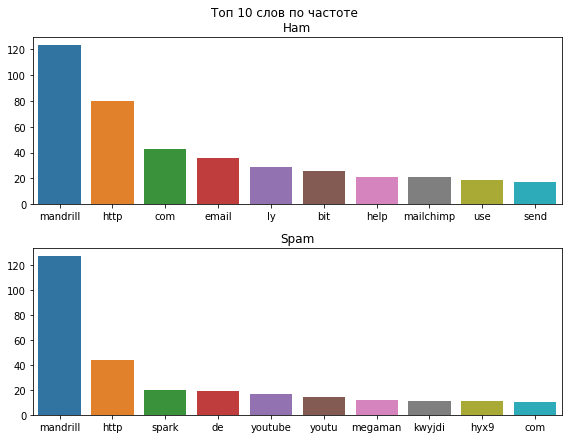

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle('Топ 10 слов по частоте', y=1.01)
sns.barplot(x=bow_ham.index[:10], y=bow_ham.values[:10], ci=95, ax=ax1)
sns.barplot(x=bow_spam.index[:10], y=bow_spam.values[:10], ci=95, ax=ax2)
ax1.set_title('Ham')
ax2.set_title('Spam')
fig.tight_layout()
plt.show()

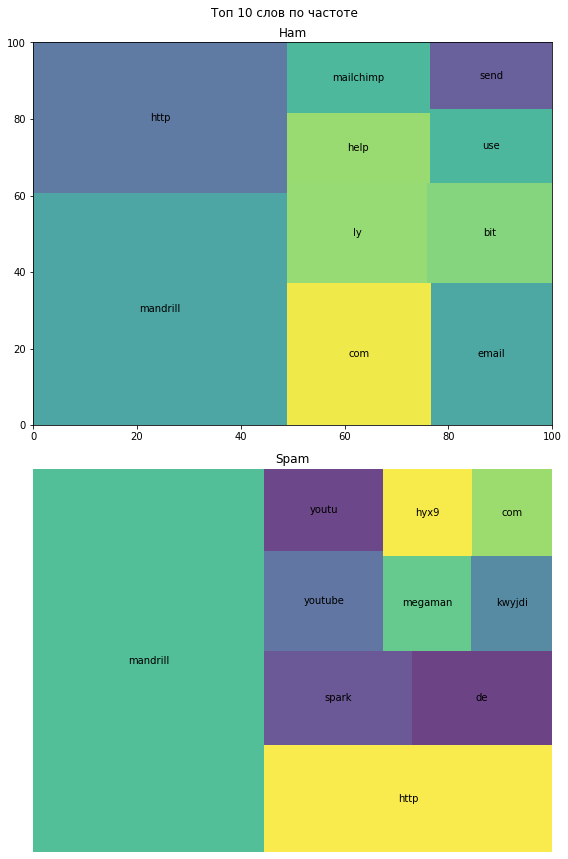

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
fig.suptitle('Топ 10 слов по частоте', y=1.01)
squarify.plot(sizes=bow_ham.values[:10], label=bow_ham.index[:10], alpha=0.8,
              ax=ax1)
squarify.plot(sizes=bow_spam.values[:10], label=bow_spam.index[:10], alpha=0.8,
              ax=ax2)
ax1.set_title('Ham')
ax2.set_title('Spam')
fig.tight_layout()
plt.axis('off')
plt.show()

## 4. Обучение классификатора

Вероятности P(S) и P(H) как доли спам и не спам сообщений.

In [34]:
# P(S) и P(H)
p_spam = len(train_spam) / len(train_bow)
p_ham = len(train_ham) / len(train_bow)
print(f'{p_spam:.2%}, {p_ham:.2%}')

51.25%, 48.75%


Условные вероятности для каждого слова вычисляются по формулам:

$P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha N_{Vocabulary}},$

$P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha N_{Vocabulary}}.$

In [35]:
# Количество уникальных слов
n_vocab = len(vocab) # Всего
n_spam = train_spam.Tokens.apply(len).sum() # В спам сообщениях
n_ham = train_ham.Tokens.apply(len).sum() # В не спам сообщениях

# Сглаживание Лапласа
alpha = 1

# Условные вероятности P(w|S) и P(w|H) для каждого уникального слова
p_word_given_spam = {unique_word: 0 for unique_word in vocab}
p_word_given_ham = {unique_word: 0 for unique_word in vocab}
for word in vocab:
  p_word_given_spam[word] = (train_spam[word].sum() + alpha) / (n_spam + alpha * n_vocab)
  p_word_given_ham[word] = (train_ham[word].sum() + alpha) / (n_ham + alpha * n_vocab)

Кумулятивная вероятность топ 30 самых популярных слов для обоих типов сообщений.

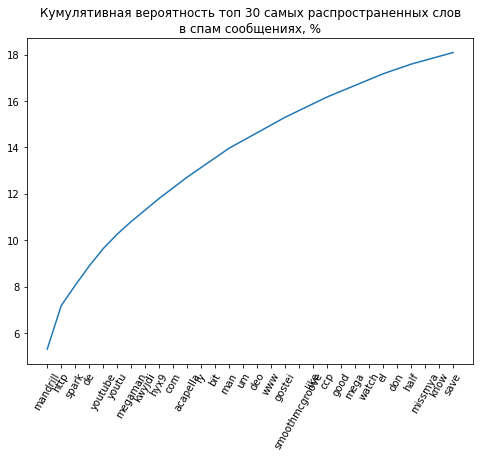

In [36]:
wp = pd.Series(p_word_given_spam).sort_values(ascending=False).head(30)\
  .cumsum() * 100
plt.figure(figsize=(8, 6))
sns.lineplot(x=wp.index, y=wp.values)
plt.xticks(rotation=60)
plt.title('Кумулятивная вероятность топ 30 самых распространенных слов\nв спам\
 сообщениях, %')
plt.show();

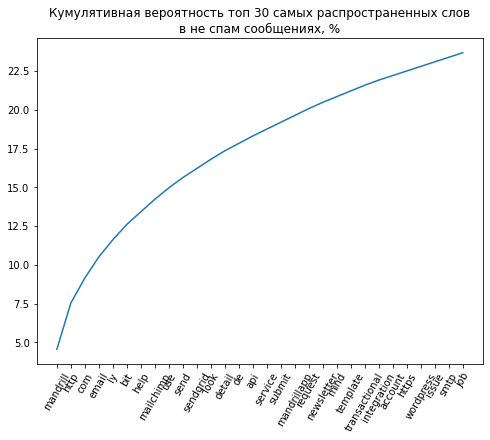

In [37]:
wp = pd.Series(p_word_given_ham).sort_values(ascending=False).head(30)\
  .cumsum() * 100
plt.figure(figsize=(8, 6))
sns.lineplot(x=wp.index, y=wp.values)
plt.xticks(rotation=60)
plt.title('Кумулятивная вероятность топ 30 самых распространенных слов\nв не\
 спам сообщениях, %')
plt.show();

## 5. Классификация тестовых данных

Проверка боем.

In [38]:
print(classify('1xbet bookmaker sports betting! Play and win!'))
print(classify('sex drugs rock n roll'))

spam
spam


Хм... ^^

Обкатаем на тестовой выборке.

In [39]:
test['Predicted'] = test.Text.apply(lambda x: classify(x, p_ham))
test.head(10)

,Text,Label,Tokens,Predicted
0,"@tamiyadd if you haven't already, can you subm...",ham,"[tamiyadd, haven, submit, request, http, help,...",ham
1,@mandrill @ccpgames i hope they record the who...,spam,"[mandrill, ccpgame, hope, record, thing, high,...",spam
2,“fat city strut” by mandrill is my new jam. ht...,spam,"[fat, city, strut, mandrill, new, jam, http, t...",ham
3,just love @mandrillapp transactional email ser...,ham,"[love, mandrillapp, transactional, email, serv...",ham
4,our love affair with transaction emails from c...,ham,"[love, affair, transaction, email, critsend, s...",ham
5,@guillaumepotier there are several reasons ema...,ham,"[guillaumepoti, reason, email, spam, mind, sub...",ham
6,our new subscriber profile page: activity time...,ham,"[new, subscriber, profile, page, activity, tim...",ham
7,"don't know how to name your novel? i say, call...",spam,"[don, know, novel, purple, mandrill, cover, fr...",ham
8,@mandrill where?.. on twitch ?,spam,"[mandrill, twitch]",spam
9,"@devongovett i'm using mandrill, but been savi...",ham,"[devongovett, use, mandrill, save, issue, doma...",ham


In [40]:
cm = confusion_matrix(
  test.Label.replace(['ham', 'spam'], [1, 0]),
  test.Predicted.replace(['ham', 'spam'], [1, 0]))
TN, FN, TP, FP = cm[0, 0], cm[1, 0], cm[1, 1], cm[0, 1]
print( 'Вопросов, шт:            ', TN + FN + TP + FP)
print( 'Правильных ответов, шт:  ', TP + TN)
print( 'Неправильных ответов, шт:', FP + FN)
print(f'Accuracy:                 {(TP + TN)/(TN + FN + TP + FP):.2%}')

Вопросов, шт:             60
Правильных ответов, шт:   54
Неправильных ответов, шт: 6
Accuracy:                 90.00%


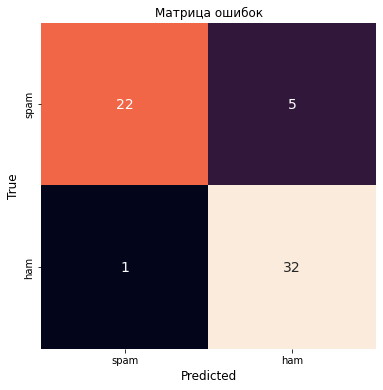

In [41]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, annot_kws={'size': 14}, cbar=False, fmt='d',
  xticklabels=['spam', 'ham'], yticklabels=['spam', 'ham'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Матрица ошибок')
plt.show()

## 6. Вывод

Разработанный спам-фильтр для SMS-сообщений на основе алгоритма наивной байесовской фильтрации был испытан на тестовой выборке из 60 сообщений. Фильтр правильно отсортировал 54 сообщениЯ и ошибся 6 раз. Метрика accuracy на тестовой выборке достигла значения 90%.